해당 경진대회는 판매량 데이터를 통해 향후 판매량을 예측하는 문제입니다.
주어지는 파일은 총 6개 중 하나는 test 파일입니다.
대충 생각해보면 범위로 분류하거나 이진분류 문제가아니기 때문에 해당 문제는 회귀문제입니다. 즉 , 연속적인 숫자값을 예측하는 문제입니다.

/content/item_categories.csv
/content/items.csv
/content/sales_train.csv
/content/sample_submission.csv
/content/shops.csv
/content/test.csv

일단은 불러와봅시다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

item_cartegories =pd.read_csv('/content/item_categories.csv')
items=pd.read_csv('/content/items.csv')
sales_train=pd.read_csv('/content/sales_train.csv')
sample_submission=pd.read_csv('/content/sample_submission.csv')
shops=pd.read_csv('/content/shops.csv')
test=pd.read_csv('/content/test.csv')

도서권수와 판매량에서와 같이 상품명과 판매량 사이에서 명확한 연관성을 구하기 힘드니 상품 카테고리로 대체하고 판매량을 추출하는것이 나아보입니다.사실상 카테고리가 더 중요한 기울기를 가지지 않을까 ? 라는 생각이 듭니다.


In [ ]:
item_cartegories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


첫번째로 sales_train 데이터를 분석해보겠습니다.

In [ ]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433007 entries, 0 to 433006
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            433007 non-null  object 
 1   date_block_num  433007 non-null  int64  
 2   shop_id         433007 non-null  int64  
 3   item_id         433007 non-null  int64  
 4   item_price      433006 non-null  float64
 5   item_cnt_day    433006 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 19.8+ MB


sales_train은 판매량 학습 데이터인데 date 는 판매날짜 shop_id는 shop id / item_id 는 아이템 번호 / item_price 는 가격 item 은 해당 월의 판매 개수인거같습니다. 아마도요 -1이면 아마도 반품되었다 이뜻이겟죠?

In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


확인해보니 같은 상품이라도 월마다 가격이 오르는 경우도 있습니다. 해당 csv는 월 "동안"을 기준 판매량이지 월간 판매량이 아닙니다.
아마도 date_block_num은 월을 나타내면서 itekm_cnt_day는 판매개수이기 때문에 2개를 기점으로 월간판매량을 만들어내야할거 같습니다. 아마도 date_block_num은 0부터 시작하는거를 봐서는 2013 1월부터 1씩 증가하여 2015 10월까지 증가하는거 같습니다.

sales_train : 2013년 1월부터 2015년 10월까지 일별 판매 내역
shops :상점에관한추가정보 ||
items :상품에관한추가정보


item_categories : 상품분류에 관한 추가 정보
test : 테스트 데이터(2015년 11월 각 상점의 상품별 월간 판매량을 예측해야 함)
sample_submission : 샘플 제출 파일

제출물은 평균 제곱근 오차(RMSE) 로 평가됩니다  . 실제 목표 값은 [0,20] 범위로 잘립니다.

타깃 데이터는 0~20까지로만 제한한다는 뜻인거같습니다. 제출값은 평균 제곱근 오차 RMSE 로 기존의 평균 제곱 오차에서 루트로 나눈값으로 평가한다는 값인거같습니다.

테스트 세트의 각 ID에 대해 총 판매 수를 예측해야 합니다. 파일에는 헤더가 포함되어야 하며 다음 형식이어야 합니다.

In [ ]:
# ID, item_cnt_month
# 0,
# 0.5 1,
# 0.5 2, 0.5 3,
# 0.5
# 등.

  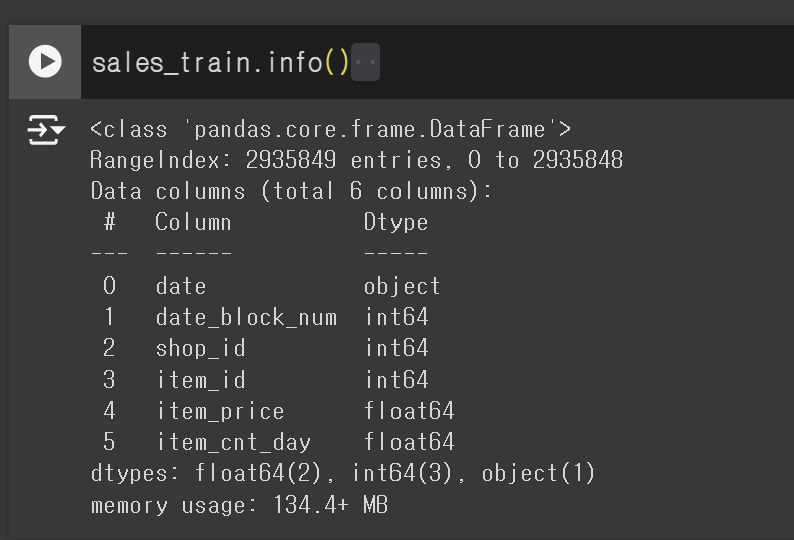

이전에 info 호출시 개수 즉 행이 출력되었는데 작동하지 않습니다. 아마도 head 호출시와 같이 너무 많아서 출력하지 않는거 같습니다.

In [ ]:

sales_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433007 entries, 0 to 433006
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            433007 non-null  object 
 1   date_block_num  433007 non-null  int64  
 2   shop_id         433007 non-null  int64  
 3   item_id         433007 non-null  int64  
 4   item_price      433006 non-null  float64
 5   item_cnt_day    433006 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 19.8+ MB


다행히도 train데이터에 null 값은 단한개도 없습니다. 순수 데이터이기 때문에 isnan과 같은처리가 필요하지않습니다.

In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
shops.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
shops["shop_name"].values

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [ ]:
len(shops["shop_name"])

60

In [ ]:
shops["shop_name"].value_counts()

,count
shop_name,
"!Якутск Орджоникидзе, 56 фран",1
"!Якутск ТЦ ""Центральный"" фран",1
"Москва ТЦ ""Серебряный Дом""",1
"Мытищи ТРК ""XL-3""",1
"Н.Новгород ТРЦ ""РИО""",1
"Н.Новгород ТРЦ ""Фантастика""",1
"Новосибирск ТРЦ ""Галерея Новосибирск""",1
"Новосибирск ТЦ ""Мега""",1
"Омск ТЦ ""Мега""",1


하나의  샵 이름에 하나의 샵 ID 가 부여되어 있습니다. 어떤 것들마다 공통된 문자가 있어서 검색해보니 앞의 한 단어는 도시를 나타내는거 같습니다. 이렇게 되면 SHOP_NAME의 경우 아까와 같이 DROP 하려했지만 도시에 따른 연관성을 부여할 수 있고 sales_train 에서 shop_id와 같은걸 포함하니 shop_id기준으로 병합을 할수 있습니다.

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
items.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [ ]:
items["item_category_id"].value_counts()

,count
item_category_id,
40,5035
55,2365
37,1780
31,1125
58,790
...,...
1,2
50,2
10,1


items 데이터를 확인해보니 대충 2만개 정도 상품이 있으며 item_category_id를 통해 84개의 카테고리 id에서 2만개정도 할당되어 있습니다.


In [ ]:
items["item_category_id"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 22170 entries, 0 to 22169
Series name: item_category_id
Non-Null Count  Dtype
--------------  -----
22170 non-null  int64
dtypes: int64(1)
memory usage: 173.3 KB


sales_train과 item 테이블은 item_id 을 공통열로 갖고 있으므로 item_id을 기준으로 병합할 수 있습니다. 상품명에서 카테고리와 같은 유의미한 데아터가 없기  때문에 카테고리 id를 사용하여 item_name을 제거하고 카테고리 속성을 사용합니다.

In [ ]:
item_cartegories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
len(item_cartegories)

84

In [ ]:
item_cartegories.value_counts()

,,count
item_category_name,item_category_id,
PC - Гарнитуры/Наушники,0,1
Книги - Художественная литература,53,1
Подарки - Атрибутика,61,1
Музыка - Подарочные издания,60,1
Музыка - Музыкальное видео,59,1
...,...,...
Игры Android - Цифра,26,1
Игры - Аксессуары для игр,25,1
Игры - XBOX ONE,24,1


하나의 카테고리 넘버에  하나의 카테고리 이름이 할당되어 있습니다. 아까와 같이 같은 텍스트를 가지고 있으니 해당 카테고리 이름도 단어를 통해 피쳐를 생성할수 있습니다.

In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


대충 이거로 테스트 하라는 거같습니다.  shop_id , item_id 가 주어집니다.

In [ ]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


sample_submission 의 경우 그냥 제출예시 csv 인거같습니다.


## 요약


[타깃 데이터] =  0 ~ 20   
[평가] = RMSE (평균 제곱근 오차)
[sales_train]
sales_train 에서 date 값은 삭제
date_block_num 은 2013 1월부터 0부터 1씩 증가
shop_id : shops 데이터에서 테이블 병합가능
item_id :  items 데이터에서 테이블 병합가능
item_price : 상품가격
item_cnt_day  :  판매개수

[shops]
shops_name : 상점이름 (첫 단어가 도시이름이기에 추가적 사용)
shop_id : sales_train 과 병합

[items]
item_name : 상품 이름 - 불필요
item_id : 상품 번호 - sales_train 과 병합
item_category_id : 카테고리 번호 -> sales_train에 병합


item_cartegories]
item_category_name :  카테고리이름  -shop_name과 같이 추가사용

위에 설명과같이 sales_train , shops , items, items_categories  와 병합합니다.`

In [ ]:
merged_sales_train =sales_train.merge(shops, on= "shop_id",how="left")
merged_sales_train  = merged_sales_train.merge(items, on= "item_id",how= "left")
merged_sales_train  = merged_sales_train.merge(item_cartegories, on= "item_category_id",how= "left")


피쳐스 리스트 함수


In [ ]:
def get_features(data):
    print(f"데이터 세트 형상: {data.shape}")
    summary =pd.DataFrame(data.dtypes,columns=["데이터 타입"])
    summary = summary.reset_index()
    summary = summary.rename(columns={"index":"컬럼명"})
    summary["결측치"] = data.isnull().sum().values
    summary["유니크"] = data.nunique().values
    summary["첫번째 값"] = data.loc[0].values
    summary["두번째 값"] = data.loc[1].values
    summary["세번째 값"] = data.loc[2].values
    return summary


In [ ]:
get_features(merged_sales_train)

데이터 세트 형상: (433007, 10)


,컬럼명,데이터 타입,결측치,유니크,첫번째 값,두번째 값,세번째 값
0,date,object,0,120,02.01.2013,03.01.2013,05.01.2013
1,date_block_num,int64,0,4,0,0,0
2,shop_id,int64,0,48,59,25,25
3,item_id,int64,0,10765,22154,2552,2552
4,item_price,float64,1,3738,999.0,899.0,899.0
5,item_cnt_day,float64,1,57,1.0,1.0,-1.0
6,shop_name,object,0,48,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
7,item_name,object,0,10765,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,58,37,58,58
9,item_category_name,object,0,58,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил


### 데이터 시각화


sales_train에서 문자데이터, 고유 id 값 제외하면 item_cnt_day , item_price 만남습니다. 두 피쳐스를 시각화하면 아래와 같습니다.

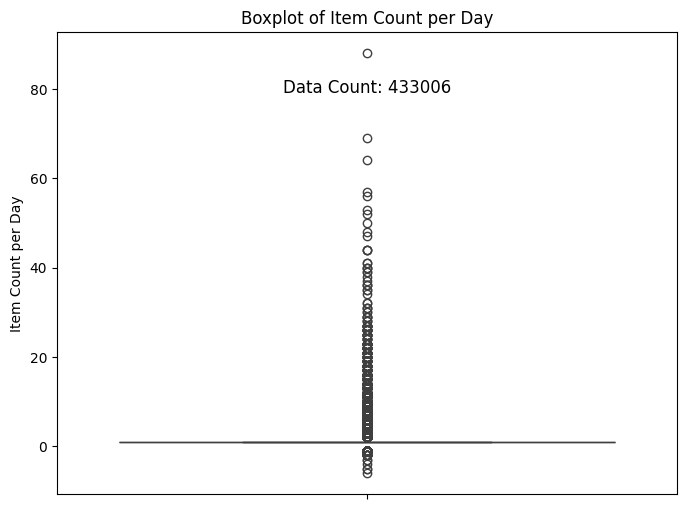

In [ ]:

# 데이터 개수 확인
data_count = sales_train['item_cnt_day'].count()

# 박스플롯 그리기
plt.figure(figsize=(8, 6))
sns.boxplot(y='item_cnt_day', data=sales_train)

# 주석 추가: 데이터 개수 표시
plt.text(0, sales_train['item_cnt_day'].max() * 0.9, f'Data Count: {data_count}',
         horizontalalignment='center', fontsize=12, color='black')

# 그래프 제목 및 레이블
plt.title('Boxplot of Item Count per Day')
plt.ylabel('Item Count per Day')
plt.show()

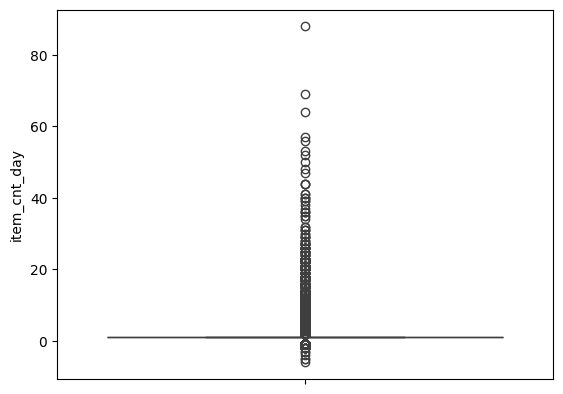

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
merged_sales_train =sales_train.merge(shops, on= "shop_id",how="left")
merged_sales_train  = merged_sales_train.merge(items, on= "item_id",how= "left")
merged_sales_train  = merged_sales_train.merge(item_cartegories, on= "item_category_id",how= "left")
sns.boxplot(y='item_cnt_day', data=merged_sales_train);

<Axes: ylabel='item_price'>

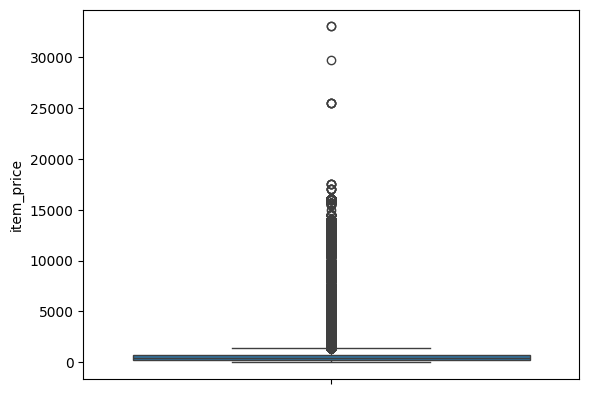

In [ ]:
sns.boxplot(y="item_price", data = merged_sales_train)

In [ ]:
merged_sales_train["item_cnt_day"].max()

88.0

In [ ]:
max_cnt_row = merged_sales_train[merged_sales_train["item_cnt_day"]==merged_sales_train["item_cnt_day"].max()]
max_cnt_row

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
239024,12.03.2013,2,31,6738,699.0,88.0,"Москва ТЦ ""Семеновский""",StarCraft II: Heart of the Swarm (дополнение) ...,30,Игры PC - Стандартные издания


In [ ]:
merged_sales_train['item_price'].max()

32990.0

In [ ]:
max_price_row = merged_sales_train[merged_sales_train["item_price"]==merged_sales_train["item_price"].max()]
max_price_row

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2113,30.01.2013,0,24,5748,32990.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса
322740,15.03.2013,2,24,5748,32990.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса


위의 표와 데이터를 보았듯이 하나의 판매량에서 1000 , 2000 이렇게 있고 가격은 300000이 넘는것이 하나 존재합니다. 이러한 것을 이상치라고 하는데 이상치는 모델에게 매우 안좋은 영향을 줍니다.

## GroupBy 사용하여 데이터 분리
월간 판매량이니 date_block_num 을 기준으로 정규화를 할거에요 판매량이니 나오는 값은 item_cnt_num 일거구요

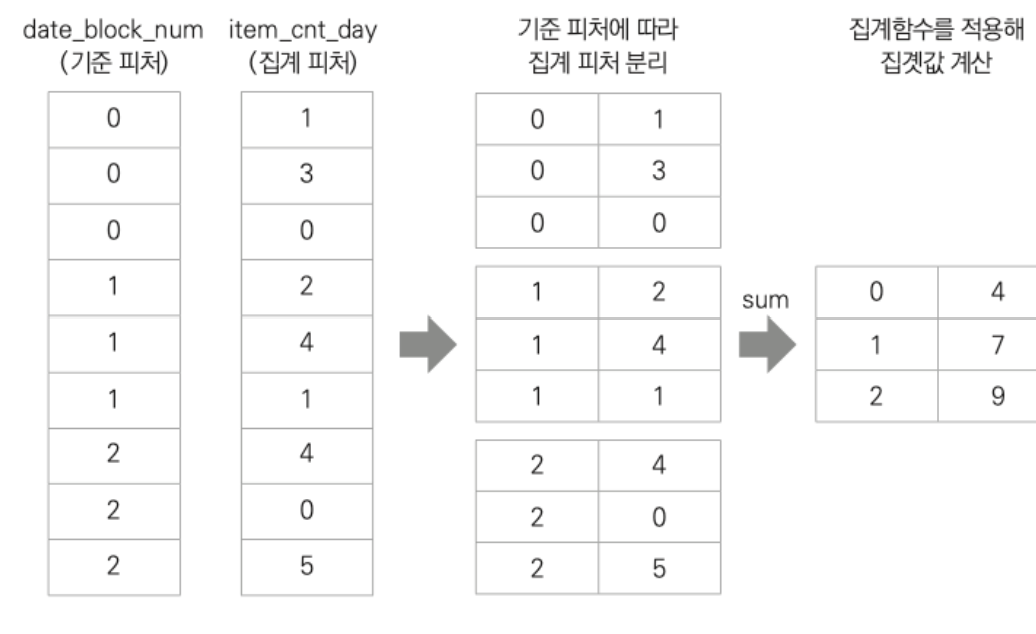

아마 이런식으로 정렬이 될겁니다.

### 월간판매량


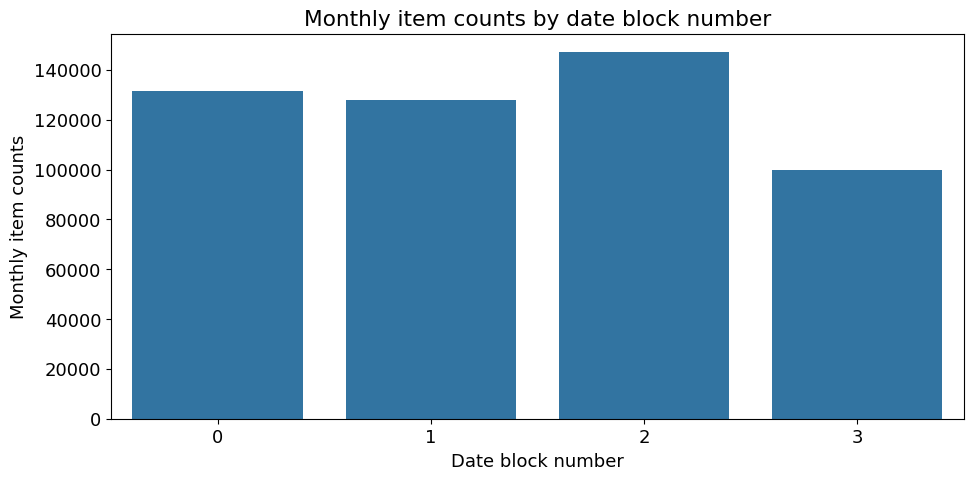

In [ ]:
mpl.rc('font', size=13)
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = merged_sales_train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Monthly item counts by date block number',
       xlabel='Date block number',
       ylabel='Monthly item counts');


11과 23에서 판매량이 매우 증가하는데 이때는 2013 .12   / 2014.12 입니다.

###상품분류별 판매량

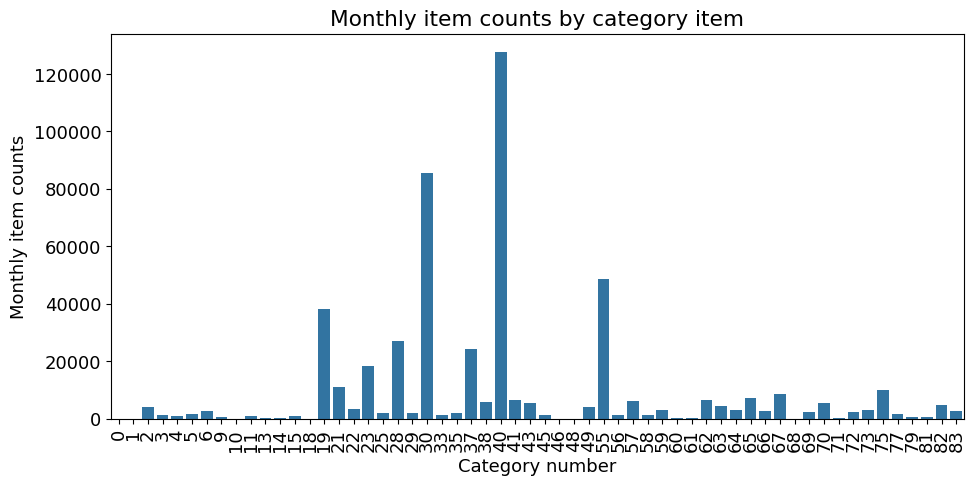

In [ ]:

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

#카테고리 별 총 상품 판매량
group_cat_sum = merged_sales_train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()


# 월별 총 상품 판매량 막대그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Monthly item counts by category item',
       xlabel='Category number',
       ylabel='Monthly item counts')
ax.tick_params(axis='x', labelrotation=90)


음 카테고리가 너무 많네요  적어도 만개는 넘은경우로 하겠습니다.

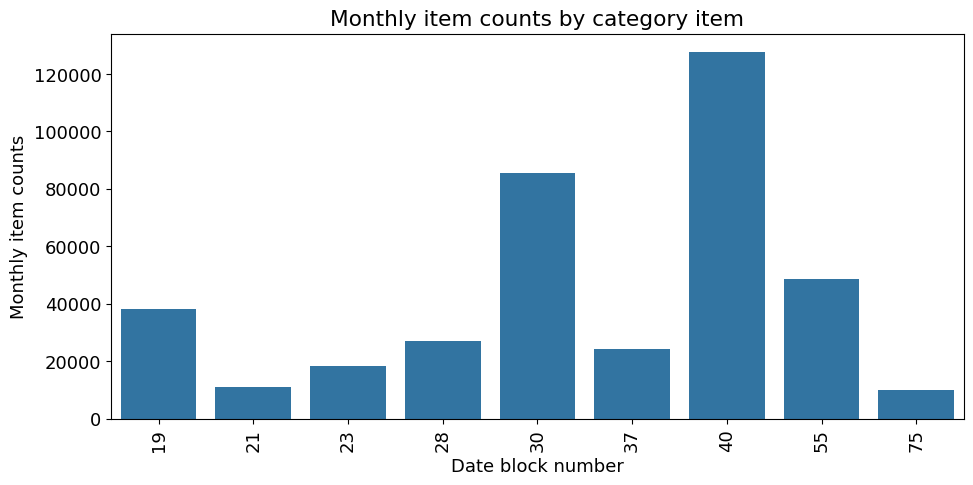

In [ ]:

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

#카테고리 별 총 상품 판매량
group_cat_sum = merged_sales_train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()
group_cat_sum_10000 = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]
# 월별 총 상품 판매량 막대그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum_10000)

# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Monthly item counts by category item',
       xlabel='Date block number',
       ylabel='Monthly item counts');
ax.tick_params(axis='x', labelrotation=90)

### 상점별 판매량

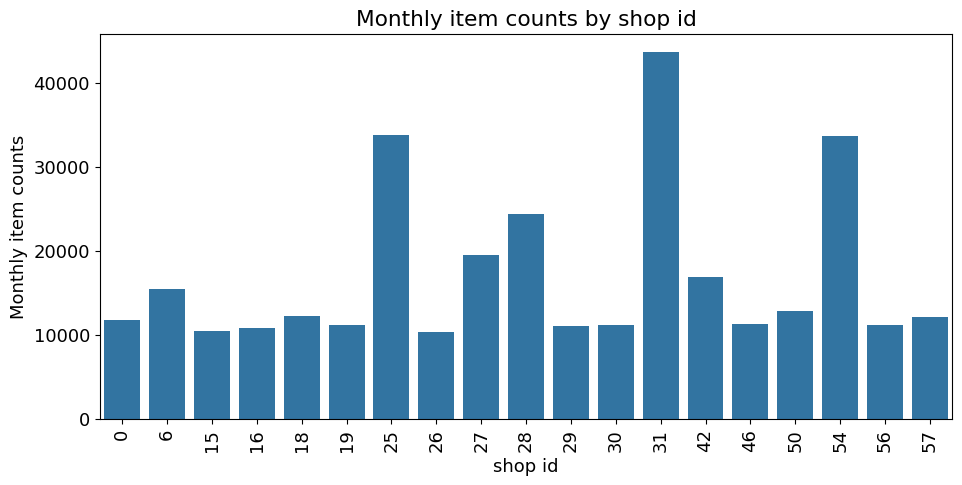

In [ ]:

figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

#카테고리 별 총 상품 판매량
group_shop_sum = merged_sales_train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()
group_shop_sum_10000 =  group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]
# 월별 총 상품 판매량 막대그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum_10000)

# 그래프 제목, x축 라벨, y축 라벨명 설정
ax.set(title='Monthly item counts by shop id',
       xlabel='shop id',
       ylabel='Monthly item counts');
ax.tick_params(axis='x', labelrotation=90)


본 글은 피처 엔지니어링에 집중합니다. 다른 모델링 요소는 최소한만 수행하겠습니다. 특히 성능 개선 단계에서는 위 분석 정리에서 미처 발견하지 못한 피처 엔지니어링도 수행합니다.

베이스라인 모델 : LightGBM
피처 엔지니어링 : 피처명 한글화, 데이터 다운캐스팅, 데이터 조합 생성, 타깃값 추가
성능 개선 : LightGBM 유지
피처 엔지니어링 : 이상치 제거, 전처리 등 다양한 파생 피처 추가, 인코딩, 결측값 처리
베이스라인 모델과 성능 개선은 다음 노트북을 리팩터링하여 작성했습니다.

### 베이스라인 모델


In [ ]:
sales_train =  sales_train.rename(columns={'date': '날짜',"date_block_num":"월ID","shop_id":"상점ID","item_id":"상품ID","item_price":"상품가격","item_cnt_day":"판매량"})

In [ ]:
sales_train

,날짜,월ID,상점ID,상품ID,상품가격,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
433002,12.04.2013,3,42,3830,399.00,1.0
433003,06.04.2013,3,42,3661,349.00,1.0
433004,20.04.2013,3,42,3661,349.00,1.0
433005,11.04.2013,3,42,3834,2199.00,1.0


In [ ]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [ ]:
shops = shops.rename(columns={'shop_name': '상점명', 'shop_id': '상점ID'})

In [ ]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [ ]:
items = items.rename(columns={'item_name': '상품명', 'item_id': '상품ID',"item_category_id":"카테고리ID" })
items

,상품명,상품ID,카테고리ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [ ]:
item_cartegories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [ ]:
item_cartegories =  item_cartegories.rename(columns={'item_category_name': '카테고리명', 'item_category_id': '카테고리ID'})

In [ ]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:

test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

In [ ]:
test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


###자료형 압축

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))


In [ ]:

all_df = [sales_train, shops, items, item_cartegories, test]
for df in all_df:
    df = downcast(df)

58.3% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


### 조합 피쳐스

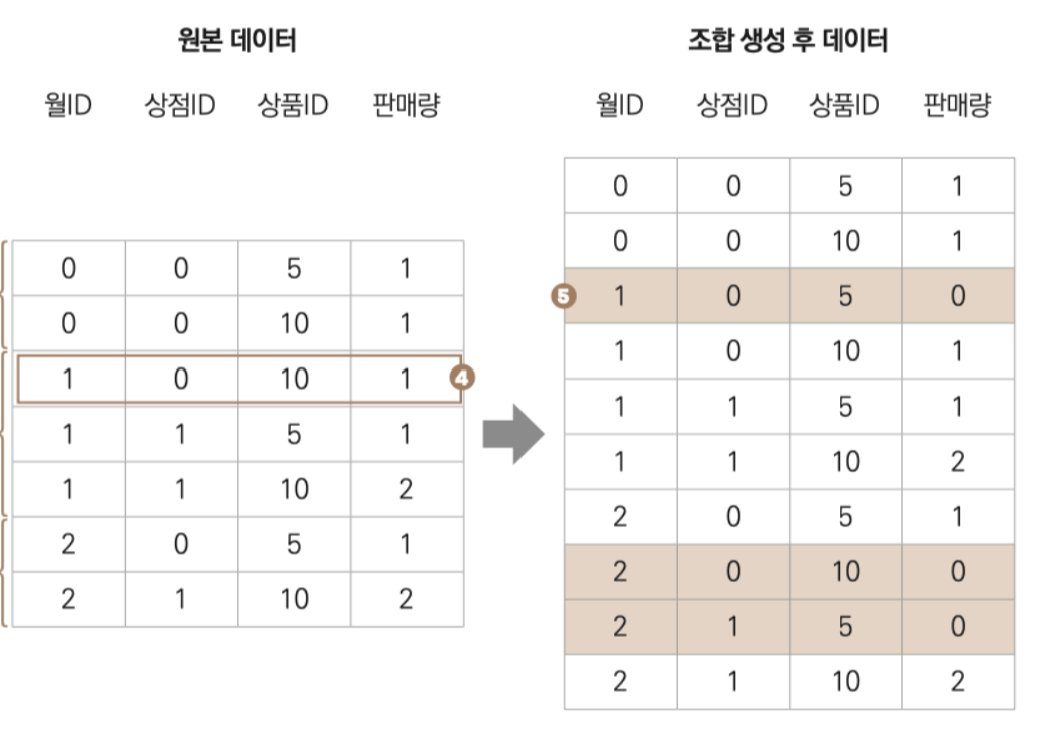

 **원본 데이터의 월ID, 상점ID, 상품ID 피처가 왼쪽과 같다고 합시다. ❶ 월ID가 0일 때 상점ID는 0, 상품ID는 5와 10이 있습니다. ❷ 월ID가 1일 때 상점ID는 0과 1, 상품ID는 5와 10이 있습니다. ❸ 월ID가 2일 때 상점ID는 0과 1, 상품ID는 5와 10이 있습니다. 월ID별로 한 번이라도 등장한 상점ID, 상품ID가 있다면 그것들의 조합을 만듭니다. 그리하여 월ID, 상점ID, 상품ID 조합을 오른쪽과 같이 만드는 겁니다. ❹ 월ID가 1일 때 상점ID 0인 상점에서는 상품ID가 5인 상품을 팔지 못했기 때문에 원본 데이터에는 월ID=1, 상점ID=0, 상품ID=5인 데이터가 아예 없습니다. 데이터가 없는 것보다는 ❺ 판매량이 0이더라도 데이터가 있는 게 낫습니다. 의미 있는 데이터는 많을수록 좋기 때문입니다. 앞 그림에서 배경색이 칠해진 부분이 조합하여 새로 만든 데이터입니다. 원본 데이터에 없는 데이터라서 판매량은 모두 0으로 지정했습니다**

즉 , 모든 상점 ID 와 상품 ID에 대해 판매량이 없다면 0으로 처리한다는 것입니다. 이 방식은 실제 데이터가 없는 경우에도 모든 가능한 조합을 생성하여 결측된 정보를 보완합니다. 해당 방법은 ITERTOOLS에서 제공하는 product 함수로 가능합니다

즉 , 각 데이터 마다 각 고유한 값을 가져오면서 조합을 해주면됩니다.

In [ ]:
from itertools import product
train =[]
# 월id  , 상점 id , 상품 id
for i in sales_train["월ID"].unique():
  all_shop = sales_train.loc[sales_train["월ID"]==i,"상점ID"].unique()
  all_item = sales_train.loc[sales_train["월ID"]==i, "상품ID"].unique()
  # train.append(pd.DataFrame(list(product([i],all_shop,all_item)),columns=["월ID","상점ID","상품ID"]))
  # 이렇게 하면
  # 모든 DataFrame을 하나로 합치기

  train.append(np.array(list(product([i], all_shop, all_item))))


idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [ ]:
train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
1468338,3,44,4695
1468339,3,44,5312
1468340,3,44,6651
1468341,3,44,6207


❶ 이 월ID, 상점ID, 상품ID 피처 조합을 만드는 코드입니다. 월ID의 고윳값(0~33)별로 모든 상점ID 고윳값, 상품ID 고윳값을 구해 조합을 생성합니다. 코드 ❶ 실행 후에 train은 34개 배열(array)을 원소로 갖게 됩니다.❷ 는 train 내 34개 배열을 하나로 합쳐 DataFrame을 만듭니다.

조합이 잘 생성됐습니다. 9.2.1절에서 살펴본 것처럼 sales_train의 데이터 개수는 2,935,849개입니다. 조합 생성 후 10,913,850개로 3.7배 정도 늘었네요.
참고로, 이렇게 만든 train을 앞으로 훈련 데이터의 뼈대로 사용합니다. 뼈대가 되는 train에 타깃값을 병합하고, 나머지 shops, items, item_categories도 병합할 것입니다.

### 피쳐 엔지니어링 타깃값


아래와 같이 하면 모든 조합식에 대한 월간판매량을 추출할 수 있습니다.`

In [ ]:
# idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
group_sale =  sales_train.groupby(idx_features).agg({"판매량":"sum"})
group_sale = group_sale.reset_index()
group_sale=group_sale.rename(columns={"판매량":"월간 판매량"})
group_sale

,월ID,상점ID,상품ID,월간 판매량
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
237298,3,59,22016,1.0
237299,3,59,22020,2.0
237300,3,59,22076,8.0
237301,3,59,22088,3.0


train 객체 : 판매가 가능한 모든 경우의 수 즉 , 없는 데이터도 있음


판매 여부와 무관: 각 조합에 대해 실제로 판매가 이루어졌는지 여부는 고려하지 않습니다.
모델 학습을 위한 기본 틀: 모든 가능한 경우를 포함함으로써, 모델이 다양한 상황을 학습할 수 있도록 돕습니다.
결측값 포함: 실제 판매되지 않은 조합의 경우 판매량이 0인 결측값을 가질 수 있습니다.




group_sale 객체 :**실제 판매가 된** 각 조합에 대한 데이터 + 월간 총판매량 => 전체 판매에서 헙계를 내었기 때문에 부분집합


### 다음으로는 sales_train 데이터와 group_sales 를 병합

In [ ]:
train = train.merge(group_sale, how="left", on=idx_features)
train

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
1468338,3,44,4695,NaN
1468339,3,44,5312,NaN
1468340,3,44,6651,NaN
1468341,3,44,6207,NaN


모든 조합에 대해 판매량을 병합한거기 때문에 월간 판매량에서 Nan값이 너무많습니다.

In [ ]:
print(train["월ID"].isna().sum(), train["상점ID"].isna().sum(), train["상품ID"].isna().sum(), train["월간 판매량"].isna().sum())

0 0 0 1231040


약 10퍼센트 정도가 결측값을 갖고 있군요. -> 추후 isna 0으로 대체

In [ ]:
import gc
del group_sale
gc.collect()

23282

In [ ]:
test

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:
test["월ID"] = 34
test

,ID,상점ID,상품ID,월ID
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [ ]:
concat_data = pd.concat([train,test. drop("ID",axis=1)],ignore_index=True,keys=idx_features)
              # 기존인덱스 무시 , idx_features를 기준으로 피쳐스 구성

concat_data

<ipython-input-63-e373781f1500>:1: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  concat_data = pd.concat([train,test. drop("ID",axis=1)],ignore_index=True,keys=idx_features)


,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
1682538,34,45,18454,NaN
1682539,34,45,16188,NaN
1682540,34,45,15757,NaN
1682541,34,45,19648,NaN


In [ ]:
concat_data=concat_data.fillna(0)
concat_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
1682538,34,45,18454,0.0
1682539,34,45,16188,0.0
1682540,34,45,15757,0.0
1682541,34,45,19648,0.0


In [ ]:
shops

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [ ]:
items

,상품명,상품ID,카테고리ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [ ]:
item_cartegories

,카테고리명,카테고리ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [ ]:
concat_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
1682538,34,45,18454,0.0
1682539,34,45,16188,0.0
1682540,34,45,15757,0.0
1682541,34,45,19648,0.0


In [ ]:
concat_data = concat_data.merge(shops, how="left", on="상점ID")
concat_data = concat_data.merge(items,how="left", on="상품ID")
concat_data = concat_data.merge(item_cartegories, how="left", on="카테고리ID")
concat_data


,월ID,상점ID,상품ID,월간 판매량,상점명,상품명,카테고리ID,카테고리명
0,0,59,22154,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2552,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,0,59,2554,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,0,59,2555,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,0,59,2564,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео
...,...,...,...,...,...,...,...,...
1682538,34,45,18454,0.0,"Самара ТЦ ""ПаркХаус""",СБ. Союз 55,55,Музыка - CD локального производства
1682539,34,45,16188,0.0,"Самара ТЦ ""ПаркХаус""",Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры
1682540,34,45,15757,0.0,"Самара ТЦ ""ПаркХаус""",НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства
1682541,34,45,19648,0.0,"Самара ТЦ ""ПаркХаус""",ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD


In [ ]:
concat_data = concat_data.drop(["상점명","상품명","카테고리명"],axis=1)

In [ ]:
concat_data=concat_data.fillna(0)


In [ ]:
concat_data

,월ID,상점ID,상품ID,월간 판매량,카테고리ID
0,0,59,22154,1.0,37
1,0,59,2552,0.0,58
2,0,59,2554,0.0,58
3,0,59,2555,0.0,56
4,0,59,2564,0.0,59
...,...,...,...,...,...
1682538,34,45,18454,0.0,55
1682539,34,45,16188,0.0,64
1682540,34,45,15757,0.0,55
1682541,34,45,19648,0.0,40


월 id 33 이하는 트레이닝 , 33은 검증용 , 34는 테스트입니다.

In [ ]:
# 트레이닝
x_train = concat_data[concat_data["월ID"]<33]
x_train = x_train.drop(["월간 판매량"],axis=1)

# 검증
x_val = concat_data[concat_data["월ID"]==33]
x_val = x_val.drop(["월간 판매량"],axis=1)

# 테스트
x_test = concat_data[concat_data["월ID"]==34]
x_test = x_test.drop(["월간 판매량"],axis=1)

y_train  = concat_data[concat_data["월ID"]<33]
y_train = y_train["월간 판매량"]
y_train = y_train.clip(lower=0,upper=20)

y_val = concat_data[concat_data["월ID"]==33]
y_val = y_val["월간 판매량"]
y_val = y_val.clip(lower=0,upper=20)

In [ ]:
x_train

,월ID,상점ID,상품ID,카테고리ID
0,0,59,22154,37
1,0,59,2552,58
2,0,59,2554,58
3,0,59,2555,56
4,0,59,2564,59
...,...,...,...,...
1468338,3,44,4695,57
1468339,3,44,5312,59
1468340,3,44,6651,22
1468341,3,44,6207,56


In [ ]:
x_val

,월ID,상점ID,상품ID,카테고리ID


In [ ]:
# del concat_data
# gc.collect()

### 모델 적용

해당 문제는 회귀문제이지만




In [ ]:
# pip install lightgbm

In [ ]:

# import lightgbm as lgb

# # LightGBM 하이퍼파라미터
# params = {'metric': 'rmse', # 평가지표 = rmse
#           'num_leaves': 255,
#           'learning_rate': 0.01,
#           'force_col_wise': True,
#           'random_state': 10}

# # 범주형 피처 설정
# cat_features = ['상점ID', '카테고리ID']

# # LightGBM 훈련 및 검증 데이터셋
# dtrain = lgb.Dataset(x_train, y_train)
# dvalid = lgb.Dataset(x_val, y_val)

# # LightGBM 모델 훈련
# lgb_model = lgb.train(params=params,
#                       train_set=dtrain,
#                       num_boost_round=500,
#                       valid_sets=(dtrain, dvalid),
#                       categorical_feature=cat_features,
# # /usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
# #   _emit_dataset_kwarg_warning("train", "categorical_feature")
# # [LightGBM] [Info] Total Bins 426
# # [LightGBM] [Info] Number of data points in the train set: 10675678, number of used features: 4
# # [LightGBM] [Info] Start training from score 0.299125

#                       )

In [ ]:
# import numpy as np
# from sklearn.metrics import mean_squared_error

# # 검증 데이터에 대한 예측
# y_pred = lgb_model.predict(x_val)

# # RMSE 계산
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Validation RMSE: {rmse}")

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [ ]:
# import catboost
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np
# # CatBoost 모델 초기화
# model = CatBoostRegressor(
#     iterations=100,  # 반복 횟수
#     learning_rate=0.1,
#     depth=6,
#     eval_metric='RMSE',
#     cat_features=['상점ID', '카테고리ID'],  # 범주형 피처
#     verbose=100  # 학습 진행 상황을 100회마다 출력
# )
# # 트레이닝
# model.fit(x_train, y_train, eval_set=(x_val, y_val), early_stopping_rounds=100)

# # 검증 데이터에 대한 예측
# y_val_pred = model.predict(x_val)

# # RMSE 계산
# rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
# print(f'Validation RMSE: {rmse:.4f}')

###성능개선

베이스라인 모델에서 추가적으로 모델의 성능을 개선하려면 피쳐스 엔지니어를을 추가하거나 하이퍼 파라미터를 최적화해야합니다.

베이스라인과 똑같이 피처명 한글화와 데이터 다운캐스팅을 합니다.
개별 데이터, 즉 sales_train, shops, items, item_categories를 활용해 전처리, 파생 피처 생성, 인코딩을 수행합니다.
베이스라인과 동일하게 데이터 조합을 만들 겁니다. 이어서 몇 가지 파생 피처를 추가합니다.


테스트 데이터를 합친 후, 2번에서 피처 엔지니어링한 다른 데이터들을 병합합니다.
시차 피처를 만듭니다. 시차 피처를 만들려면 먼저 ‘기준 피처별 월간 평균 판매량 피처’를 구해야 합니다. 이 피처를 기반으로 시차 피처를 만들 것입니다.
마지막으로 그 외 추가적인 피처 엔지니어링을 적용합니다.
1, 3, 4번은 베이스라인과 거의 같고, 2, 5, 6번을 추가로 수행하는 것입니다. 이렇게 공들여 만든 데이터로 LightGBM 모델을 훈련하여 성능이 얼마나 좋아지는지 보겠습니다.




가장 먼저 데이터를 불러옵니다. 코드는 베이스라인과 똑같습니다.

시차 피쳐란 과거시점의 데이터를 현재 시점의 데이터에 반영하는 피쳐

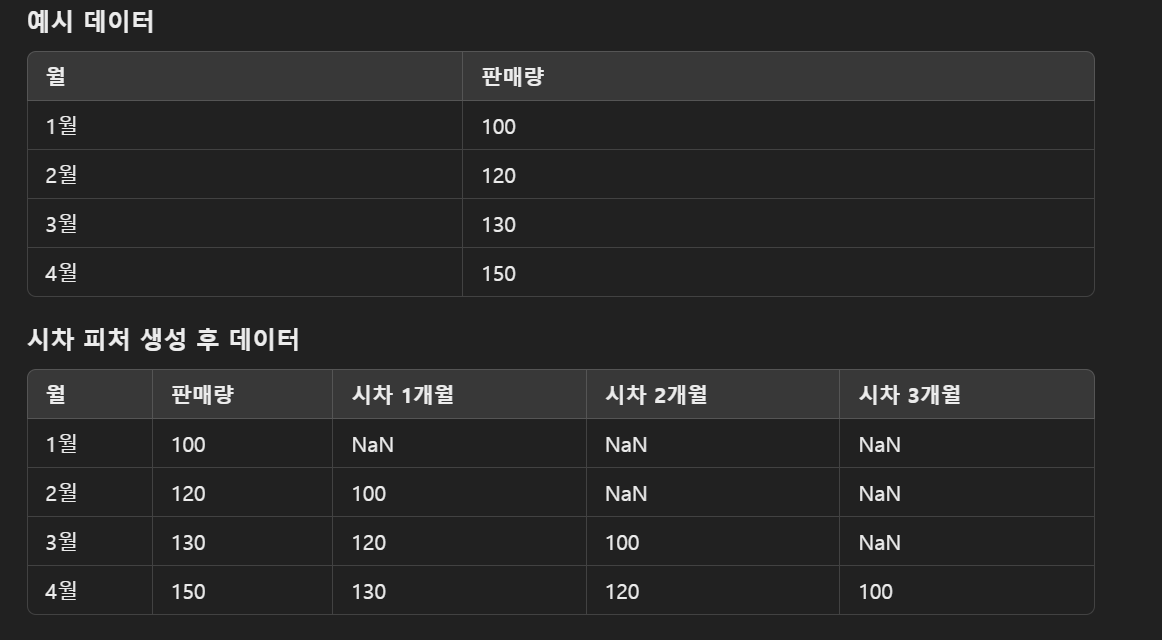

시차 피처를 활용하는 방식은 과거 데이터를 사용해 미래의 값을 예측하고, 그 예측값과 실제 타겟값(실제 결과) 사이의 차이를 최소화하는 방향으로 모델을 학습시키는 것입니다.

In [ ]:

item_cartegories =pd.read_csv('/content/item_categories.csv')
items=pd.read_csv('/content/items.csv')
sales_train=pd.read_csv('/content/sales_train.csv')
sample_submission=pd.read_csv('/content/sample_submission.csv')
shops=pd.read_csv('/content/shops.csv')
test=pd.read_csv('/content/test.csv')

In [ ]:
sales_train = sales_train.rename(columns={'date': '날짜',
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})


item_cartegories = item_cartegories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})
test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

In [ ]:

def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))

    return df

all_df = [sales_train, shops, items, item_cartegories, test]
for df in all_df:
    df = downcast(df)

50.0% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


In [ ]:
sales_train = sales_train[sales_train["판매가"]>  0]
sale_train = sales_train[sales_train["판매가"]<50000]

sales_train =  sales_train[sales_train["판매량"]> 0 ]
sales_train =  sales_train[sales_train["판매량"]<1000]

In [ ]:

print(shops['상점명'][0], '||', shops['상점명'][57])
print(shops['상점명'][1], '||', shops['상점명'][58])
print(shops['상점명'][10], '||', shops['상점명'][11])
print(shops['상점명'][39], '||', shops['상점명'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


위에 보이다 시피 위의 출력들은 같은 뜻입니다.

In [ ]:
 sales_train

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
1321539,02.01.2014,12,38,1481,1399.00,1.0
1321540,11.01.2014,12,38,1475,698.00,1.0
1321541,22.01.2014,12,38,1470,699.00,1.0
1321542,31.01.2014,12,38,1461,719.52,1.0


In [ ]:
test

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:

test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

In [ ]:
# sales_train 데이터에서 상점ID 수정
sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

# test 데이터에서 상점ID 수정
test.loc[test['상점ID'] == 0, '상점ID'] = 57
test.loc[test['상점ID'] == 1, '상점ID'] = 58
test.loc[test['상점ID'] == 10, '상점ID'] = 11
test.loc[test['상점ID'] == 39, '상점ID'] = 40

In [ ]:
shops["도시"] = shops["상점명"].apply(lambda x : x.split()[0])

In [ ]:
shops

,상점명,상점ID,도시
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная


In [ ]:
shops["도시"].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [ ]:
shops.loc[shops["도시"]=="!Якутск", "도시"] = "Якутск"

In [ ]:
shops

,상점명,상점ID,도시
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная


러시아 각 도시 이름 숫자 ID 로 변환

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder=LabelEncoder()
shops["도시"] = label_encoder.fit_transform(shops["도시"])


In [ ]:
shops

,상점명,상점ID,도시
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2
5,"Вологда ТРЦ ""Мармелад""",5,3
6,"Воронеж (Плехановская, 13)",6,4
7,"Воронеж ТРЦ ""Максимир""",7,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,4
9,Выездная Торговля,9,5


In [ ]:
shops=shops.drop("상점명",axis=1)
shops

,상점ID,도시
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


In [ ]:
items

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [ ]:
items=items.drop("상품명", axis=1)

In [ ]:
items

,상품ID,상품분류ID
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
...,...,...
22165,22165,31
22166,22166,54
22167,22167,49
22168,22168,62


### 피처스 엔지니어링  - 1

상품이 처음팔린 월 생성

In [ ]:
sales_train

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
1321539,02.01.2014,12,38,1481,1399.00,1.0
1321540,11.01.2014,12,38,1475,698.00,1.0
1321541,22.01.2014,12,38,1470,699.00,1.0
1321542,31.01.2014,12,38,1461,719.52,1.0


In [ ]:
items

,상품ID,상품분류ID
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
...,...,...
22165,22165,31
22166,22166,54
22167,22167,49
22168,22168,62


In [ ]:
items['첫 판매월'] = sales_train.groupby('상품ID').agg({'월ID': 'min'})['월ID']
items


,상품ID,상품분류ID,첫 판매월
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
...,...,...,...
22165,22165,31,7.0
22166,22166,54,9.0
22167,22167,49,8.0
22168,22168,62,0.0


In [ ]:
items[items['첫 판매월'].isna()]

,상품ID,상품분류ID,첫 판매월
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
...,...,...,...
22159,22159,40,NaN
22162,22162,40,NaN
22163,22163,40,NaN
22164,22164,37,NaN


첫판매월이 NaN 인 값은 2013년 1월 부터 2015 10월까지 판매 되지 않은 상품이며  판매내역의 월ID 는 0~33입니다. 34는 test 데이터 판매월 ID 입니다.

2015 11월 까지 팔리지 않았다면 그상품은 처음 팔린 달이 2015.11로 해도 됩니다.

첫 판매월 피쳐 결측값을  34로 해도 된다는 것입니다.

2015.11에도 팔리지 않았다 해도 해당 데이터는 고려 대상이 아니기 때문에 상관이 없습니다.

테스트 데이터 2015.11에도 팔렸다면 중복으로 들어가는 경우가 있겠지만



훈련 데이터 기간 동안 판매되지 않은 상품:
훈련 데이터 기간 동안 판매되지 않은 상품의 첫 판매월이 34 (즉, 2015년 11월)인 것은, 해당 상품이 최초로 판매된 시점이 테스트 기간이라는 것을 의미합니다.
이는 전혀 이상한 상황이 아닙니다. 훈련 데이터에는 기록되지 않았지만, 테스트 기간에 처음으로 판매될 수 있는 상품이 존재할 수 있습니다.
테스트 데이터의 목적:
테스트 데이터는 모델이 훈련 데이터에서 학습한 내용을 바탕으로 2015년 11월의 판매량을 예측하는 데 사용됩니다.
훈련 데이터에 없는 새로운 상품이 테스트 데이터에 포함될 수 있으며, 모델은 이러한 새로운 상품에 대한 판매량도 예측해야 합니다.
결론적으로,

첫 판매월에 34가 들어간다는 것은, 해당 상품이 훈련 데이터 기간에는 판매되지 않았지만, 테스트 기간인 2015년 11월에 처음으로 판매되었다는 것을 의미합니다.
이는 전혀 이상한 상황이 아니며, 오히려 모델이 새로운 상품에 대한 판매량을 예측하는 능력을 평가하는 데 필요한 데이터입니다.

  

훈련 데이터에서 첫 판매월이 결측된 값을 모두 34로 채우는 것은, 모델 입장에서 해당 상품들이 테스트 데이터에서 처음으로 판매될 가능성이 높다고 가정하는 것과 같습니다.

In [ ]:

# 첫 판매월 피처의 결측값을 34로 대체
items['첫 판매월'] = items['첫 판매월'].fillna(34)

In [ ]:
items

,상품ID,상품분류ID,첫 판매월
0,0,40,34.0
1,1,76,34.0
2,2,40,34.0
3,3,40,34.0
4,4,40,34.0
...,...,...,...
22165,22165,31,7.0
22166,22166,54,9.0
22167,22167,49,8.0
22168,22168,62,0.0


In [ ]:
items[items['첫 판매월'].isna()]

,상품ID,상품분류ID,첫 판매월


In [ ]:
items[items["첫 판매월"] == 34]

,상품ID,상품분류ID,첫 판매월
0,0,40,34.0
1,1,76,34.0
2,2,40,34.0
3,3,40,34.0
4,4,40,34.0
...,...,...,...
22159,22159,40,34.0
22162,22162,40,34.0
22163,22163,40,34.0
22164,22164,37,34.0


In [ ]:
item_cartegories

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [ ]:

item_cartegories = item_cartegories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

In [ ]:
item_cartegories["대분류"] =  item_cartegories["상품분류명"].apply(lambda x :  x.split()[0])
item_cartegories

,상품분류명,상품분류ID,대분류
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [ ]:
item_cartegories["대분류"].value_counts()

,count
대분류,
Игры,14
Книги,13
Подарки,12
Игровые,8
Аксессуары,7
Музыка,6
Программы,6
Карты,5
Кино,5


In [ ]:
item_cartegories["대분류"].unique()

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype=object)

In [ ]:
def make_etc(x):
  if len(item_cartegories[item_cartegories["대분류"]==x])>= 5:
    return x
  else:
    return "기타"


item_cartegories["대분류"] = item_cartegories["대분류"].apply(make_etc)


고유값 5개 미만인 경우 기타 처리

In [ ]:
item_cartegories

,상품분류명,상품분류ID,대분류
0,PC - Гарнитуры/Наушники,0,기타
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,기타
80,Служебные - Билеты,80,기타
81,Чистые носители (шпиль),81,기타
82,Чистые носители (штучные),82,기타


In [ ]:
label_encoder = LabelEncoder()
item_cartegories["대분류"] = label_encoder.fit_transform(item_cartegories["대분류"])
item_cartegories=item_cartegories.drop("상품분류명", axis =1)

In [ ]:
item_cartegories

,상품분류ID,대분류
0,0,9
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
79,79,9
80,80,9
81,81,9
82,82,9


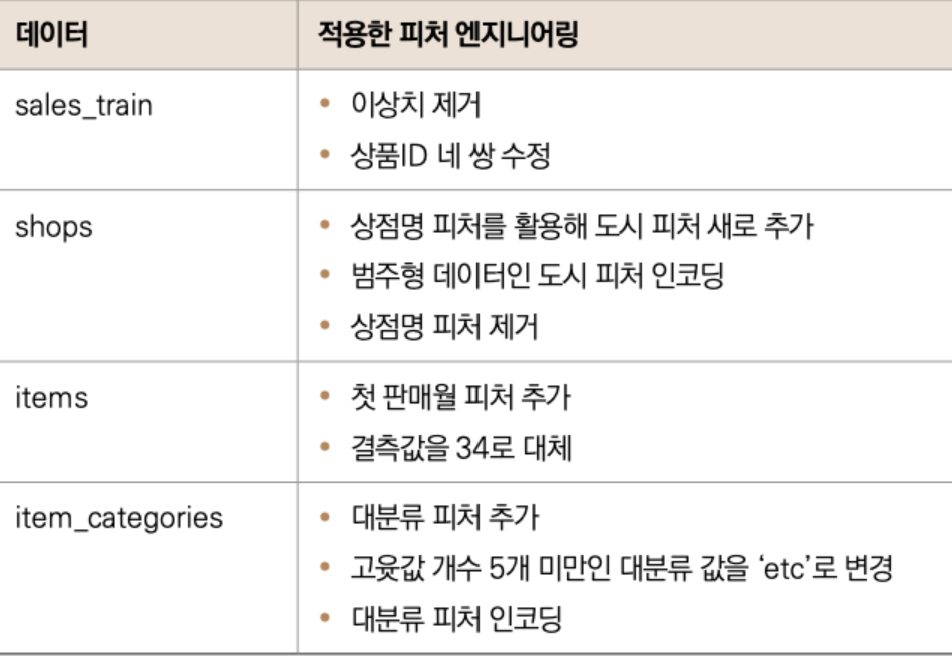

### 데이터 조합 및 파생 피쳐 생성

In [ ]:

from itertools import product
import pandas as pd

In [ ]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [ ]:
all_shop

array([54, 55, 51, 52, 53, 58, 57, 59,  2, 56, 46, 31, 35, 37, 28, 27, 30,
       29, 43, 42, 47, 50, 49, 41, 44, 38], dtype=int8)

In [ ]:
all_item

array([10297, 10296, 10298, ...,   717,   677,   565], dtype=int16)

In [ ]:
train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
4650485,12,38,1602
4650486,12,38,1027
4650487,12,38,717
4650488,12,38,677


### 파생 피처 생성

In [ ]:
group = sales_train.groupby(idx_features).agg({'판매량':"sum", "판매가":"mean"})
group = group.reset_index()
group = group.rename(columns={'판매량': '월간 판매량', '판매가': '평균 판매가'})
train = train.merge(group, on=idx_features, how='left')

In [ ]:
train

,월ID,상점ID,상품ID,월간 판매량,평균 판매가
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN
...,...,...,...,...,...
4650485,12,38,1602,1.0,58.0
4650486,12,38,1027,1.0,28.0
4650487,12,38,717,1.0,149.0
4650488,12,38,677,1.0,149.0


In [ ]:
import gc

# group 변수 가비지 컬렉션
del group
gc.collect();

In [ ]:

# 상품 판매건수 피처 추가
group = sales_train.groupby(idx_features).agg({'판매량': 'count'})
group = group.reset_index()
group = group.rename(columns={'판매량': '판매건수'})

train = train.merge(group, on=idx_features, how='left')

# 가비지 컬렉션
del group, sales_train
gc.collect()

train.head()


,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


### 데이터 합치기

In [ ]:
test['월ID'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

<ipython-input-129-8dce901ce15d>:4: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  all_data = pd.concat([train, test.drop('ID', axis=1)],


,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [ ]:
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [ ]:

# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_cartegories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

66.7% 압축됨


In [ ]:
# 가비지 컬렉션
del shops, items, item_cartegories
gc.collect();

### 피쳐 엔지니어링 : 시차 피처 생성


시차 피처time lag feature란 과거 시점에 관한 피처로, 성능 향상에 도움되는 경우가 많아서 시계열 문제에서 자주 만드는 파생 피처입니다

시차 피처를 만들려면 기준으로 삼을 피처를 먼저 정해야 합니다. 이번 경진대회라면 타깃값과 관련된 ‘월간 평균 판매량’이 좋겠네요. 그렇기 때문에 시차 피처를 구하기에 앞서 ‘기준 피처별 월간 평균 판매량’ 피처를 만들어야 합니다.

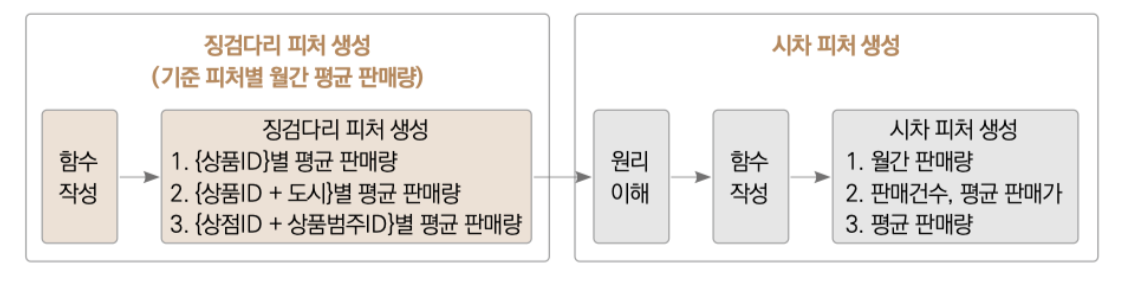

df : 작업할 전체 데이터(DataFrame)

mean_features : 새로 만든 월간 평균 판매량 파생 피처명을 저장하는 리스트

idx_features : 기준 피처

In [ ]:
def add_mean_features(df, mean_features, idx_features):
    # 기준 피처 확인
    assert (idx_features[0] == '월ID') and \
           len(idx_features) in [2, 3]

    # 파생 피처명 설정
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'

    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기
    group = df.groupby(idx_features).agg({'월간 판매량': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'월간 판매량': feature_name})

    # df와 group 병합
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가
    mean_features.append(feature_name)

    # 가비지 컬렉션
    del group
    gc.collect()

    return df, mean_features

In [ ]:

# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID'])

# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID', '도시'])

In [ ]:
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

In [ ]:
shop_mean_features  =  []
all_data,  shop_mean_features  = add_mean_features(df= all_data , mean_features =  shop_mean_features  , idx_features = ['월ID' , '상점ID', "상품분류ID"])
#

In [ ]:
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

### 현재 까지의 피처별 평균 판매량
{상품ID}별 평균 판매량

{상품ID + 도시}별 평균 판매량

{상점ID + 상품범주ID}별 평균 판매량


기준 피쳐 : 월 ID  || 상점ID || 상품ID

시차값을 구하려는 피처 : 월간 판매량

기준 피처를 통해 시차별로 월간  판매량을 생성할 수 있습니다.


시계열 문제에서 시차 피처(lag features)를 사용하는 이유는 과거 데이터를 기반으로 미래를 예측할 때, 과거 값들이 미래에 영향을 미칠 수 있기 때문입니다. 시차 피처를 활용하면 시간에 따른 패턴이나 상관관계를 효과적으로 모델에 반영할 수 있습니다.

시차 피처는 시계열 문제에서 과거 값들을 통해 그 사이 값들을 통해 테스트 데이터에 대한 타깃을 예측할수 있도록 합니다.

시차 피처스에 대한 일반적인 가이드라인으로는 1~3개의 시차 피쳐스를 사용하며

전체 데이터의 5~10 퍼센트의 시차 피처를 사용합니다.



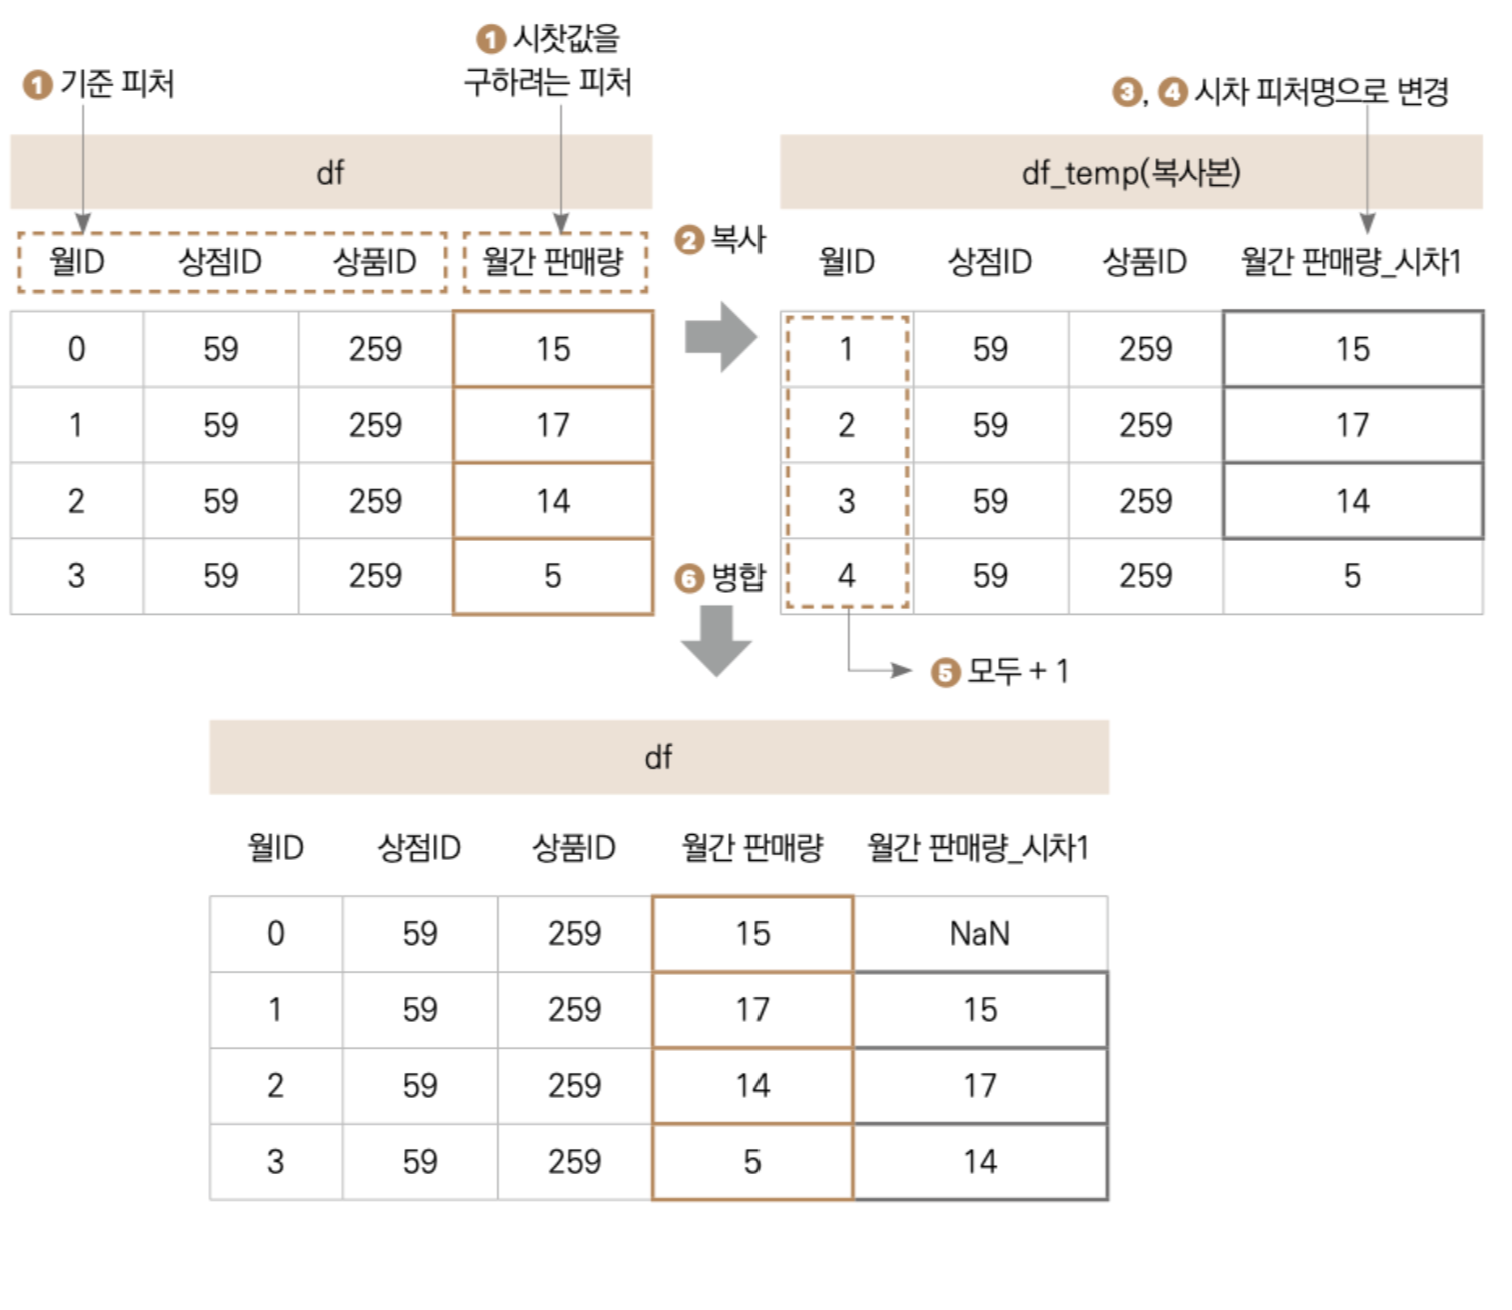

nlags 가 증가할 수록 월간 판매량 시차가 증가합니다.

In [ ]:
def add_lag_features(df, lag_features_to_clip, idx_features,
                     lag_feature, nlags=3, clip=False):
    # 시차 피처 생성에 필요한 DataFrame 부분만 복사
    df_temp = df[idx_features + [lag_feature]].copy()
    # idx_feat 은 기존 피쳐스 , lag_feature 배열에 해당하는 피쳐스 할당
    # 시차 피처 생성
    for i in range(1, nlags+1): # 첫번째 부터  마지막 피쳐스까지 횟수 반복
        # 시차 피처명
        lag_feature_name = lag_feature +'_시차' + str(i) # lag_feature는 하나의 문자열
        # df_temp 열 이름 설정
        df_temp.columns = idx_features + [lag_feature_name] # 열이름 변경
        # df_temp의 date_block_num 피처에 1 더하기
        df_temp['월ID'] += 1
        # idx_feature를 기준으로 df와 df_temp 병합하기
        df = df.merge(df_temp.drop_duplicates(),
                      on=idx_features,
                      how='left') # 월 ID , 상점 ID , 상품ID 기준으로 병합
        # 결측값 0으로 대체
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # 0 ~ 20 사이로 제한할 시차 피처명을 lag_features_to_clip에 추가
        if clip:
            lag_features_to_clip.append(lag_feature_name)

    # 데이터 다운캐스팅
    df = downcast(df, False)
    # 가비지 컬렉션
    del df_temp
    gc.collect()

    return df, lag_features_to_clip

In [ ]:
iag_feature_to_clip =  [] # 0~20으로 제한 할  시차 피쳐명
idx_features= ["월ID","상점ID", "상품ID"]
all_data , iag_feature_to_clip =  add_lag_features(df= all_data , lag_features_to_clip=iag_feature_to_clip , idx_features=idx_features , lag_feature="월간 판매량", nlags=3, clip=True)
all_data


,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수,도시,상품분류ID,첫 판매월,대분류,상품ID별 평균 판매량,상품ID 도시별 평균 판매량,상점ID 상품분류ID별 평균 판매량,월간 판매량_시차1,월간 판매량_시차2,월간 판매량_시차3
0,0,59,22154,1,999.0,1,30,37,0,4,0.400000,1.0,0.088496,0,0,0
1,0,59,2552,0,0.0,0,30,58,0,6,0.022222,0.0,0.000000,0,0,0
2,0,59,2554,0,0.0,0,30,58,0,6,0.022222,0.0,0.000000,0,0,0
3,0,59,2555,0,0.0,0,30,56,0,6,0.044444,0.0,0.008333,0,0,0
4,0,59,2564,0,0.0,0,30,59,0,6,0.111111,0.0,0.011976,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4864685,34,45,18454,0,0.0,0,20,55,34,6,0.000000,0.0,0.000000,0,0,0
4864686,34,45,16188,0,0.0,0,20,64,34,7,0.000000,0.0,0.000000,0,0,0
4864687,34,45,15757,0,0.0,0,20,55,0,6,0.000000,0.0,0.000000,0,0,0
4864688,34,45,19648,0,0.0,0,20,40,34,4,0.000000,0.0,0.000000,0,0,0


In [ ]:
iag_feature_to_clip

['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']

 df_temp는 원래 데이터프레임에서 특정 열만 복사한 후, 월ID를 매번 1씩 증가시키면서 시차 피처를 생성하는 구조

### 시차 피처 :  판매건수 , 평균 판매가

판매건수와 평균 판매가에 대한 시차 생성

판매건수, 평균 판매가는 타깃값(월간판매량)이 아니기 때문에 clip 인자 True 미처리



In [ ]:
all_data ,iag_feature_to_clip  = add_lag_features(df=all_data,lag_features_to_clip=iag_feature_to_clip , idx_features=idx_features,lag_feature="판매건수", nlags=3 )
all_data , iag_feature_to_clip = add_lag_features(df=all_data,lag_features_to_clip=iag_feature_to_clip , idx_features=idx_features,lag_feature="평균 판매가", nlags=3 )

판매건수 시차는 월ID가 다른 경우에 대해 같은 상점ID, 상품ID에서 하루 단위로 판매된 수량을 의미합니다.

### 시차 피처 생성 : 평균 판매량

In [ ]:

# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, iag_feature_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=iag_feature_to_clip,
                                                      idx_features=idx_features,
                                                      lag_feature=item_mean_feature,
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

KeyError: "['상품ID별 평균 판매량'] not in index"

In [ ]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, iag_feature_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=iag_feature_to_clip,
                                                      idx_features=['월ID', '상점ID', '상품분류ID'],
                                                      lag_feature=shop_mean_feature,
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

KeyError: "['상점ID 상품분류ID별 평균 판매량'] not in index"

### 시차 피처 생성에 따른 결측값

3개월치 씩 하기 때문에  월 ID가 3미만인 데이터는 제거합니다.

In [ ]:

# 월ID 3미만인 데이터 제거
all_data = all_data.drop(all_data[all_data['월ID'] < 3].index)

### 피처 엔지니어링 : 기타 피처 엔지니어링

시차 평균 추가

In [ ]:

all_data['월간 판매량 시차평균'] = all_data[['월간 판매량_시차1',
                                          '월간 판매량_시차2',
                                          '월간 판매량_시차3']].mean(axis=1)


In [ ]:
all_data[iag_feature_to_clip + ['월간 판매량', '월간 판매량 시차평균']] = all_data[iag_feature_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0, 20)

### 시차 변화량
시차변화량1 = 월간 판매량_시차1 / 월간 판매량_시차2
시차변화량2 = 월간 판매량_시차2 / 월간 판매량_시차3

In [ ]:

all_data['시차변화량1'] = all_data['월간 판매량_시차1']/all_data['월간 판매량_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf],
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['월간 판매량_시차2']/all_data['월간 판매량_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf],
                                                        np.nan).fillna(0)

In [ ]:
# # # replace([np.inf, -np.inf], np.nan).fillna(0) 부분은 값을 0으로 나누는 상황을 대처하는 방어 코드입니다. 양수를 0으로 나누면 무한대(np.inf)가 되고,
#  음수를 0으로 나누면 무한소(-np.inf)가 됩니다.
# # 이런 경우 np.inf와 -np.inf를 0으로 바꾸는 일을 해주죠.

### 신상여부  , 첫판매 후 기간 피처스 추가

In [ ]:
all_data['신상여부'] = all_data['첫 판매월'] == all_data['월ID']

In [ ]:
all_data['첫 판매 후 기간'] = all_data['월ID'] - all_data['첫 판매월']

In [ ]:

all_data['월'] = all_data['월ID'] % 12
# 첫 판매월, 평균 판매가, 판매건수 피처 제거
all_data = all_data.drop(['첫 판매월', '평균 판매가', '판매건수'], axis=1)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742304 entries, 1122386 to 4864689
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   월ID                      int8   
 1   상점ID                     int8   
 2   상품ID                     int16  
 3   월간 판매량                   int16  
 4   도시                       int8   
 5   상품분류ID                   int8   
 6   대분류                      int8   
 7   월간 판매량_시차1               int16  
 8   월간 판매량_시차2               int16  
 9   월간 판매량_시차3               int16  
 10  판매건수_시차1                 int8   
 11  판매건수_시차2                 int8   
 12  판매건수_시차3                 int8   
 13  평균 판매가_시차1               float64
 14  평균 판매가_시차2               float64
 15  평균 판매가_시차3               float64
 16  상품ID별 평균 판매량_시차1         float32
 17  상품ID별 평균 판매량_시차2         float32
 18  상품ID별 평균 판매량_시차3         float32
 19  상품ID 도시별 평균 판매량_시차1      float32
 20  상품ID 도시별 평균 판매량_시차2      float32
 21  상품

In [ ]:

# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']

# 가비지 컬렉션
del all_data
gc.collect();

In [2]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10}

cat_features = ['상점ID', '도시', '상품분류ID', '대분류', '월']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features)

NameError: name 'x_train' is not defined